In [1]:
import os
os.listdir('../input')

# Any results you write to the current directory are saved as output.

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../input'

crop, resize images and save them to folder

20579
120


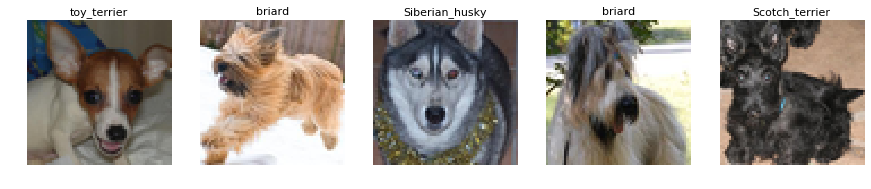

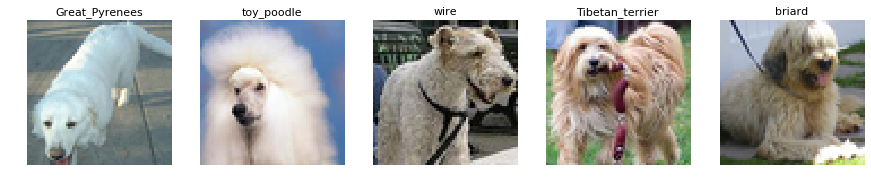

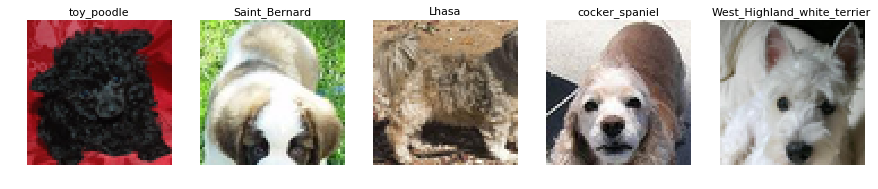

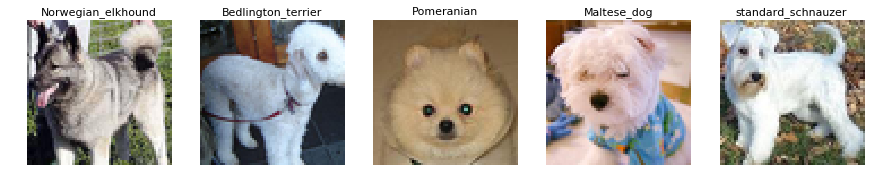

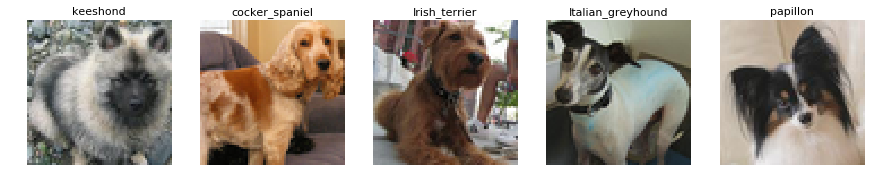

In [2]:
DogsOnly = True

import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 
from glob import glob

ROOT = '../input/'
IMAGES = os.listdir(ROOT + 'all-dogs/all-dogs')
print(len(IMAGES))
breeds = os.listdir(ROOT + 'annotation/Annotation') 
print(len(breeds))

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))

# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
# https://www.kaggle.com/paulorzp/show-annotations-and-breeds
if DogsOnly:
    for breed in breeds:
        for dog in os.listdir(ROOT+'annotation/Annotation/'+breed):
            try: img = Image.open(ROOT+'all-dogs/all-dogs/'+dog+'.jpg') 
            except: continue           
            tree = ET.parse(ROOT+'annotation/Annotation/'+breed+'/'+dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                img2 = img2.resize((64,64), Image.ANTIALIAS)
                imagesIn[idxIn,:,:,:] = np.asarray(img2)
                #if idxIn%1000==0: print(idxIn)
                namesIn.append(breed)
                idxIn += 1
                
                if not os.path.exists(f"temp/cropped_images"):
                  os.makedirs(f"temp/cropped_images")
                img2.save(f"temp/cropped_images/{dog}.png")
    idx = np.arange(idxIn)
    np.random.shuffle(idx)
    imagesIn = imagesIn[idx,:,:,:]
    namesIn = np.array(namesIn)[idx]
    
# RANDOMLY CROP FULL IMAGES
else:
    x = np.random.choice(np.arange(20579),10000)
    for k in range(len(x)):
        img = Image.open(ROOT + 'all-dogs/all-dogs/' + IMAGES[x[k]])
        w = img.size[0]
        h = img.size[1]
        sz = np.min((w,h))
        a=0; b=0
        if w<h: b = (h-sz)//2
        else: a = (w-sz)//2
        img = img.crop((0+a, 0+b, sz+a, sz+b))  
        img = img.resize((64,64), Image.ANTIALIAS)   
        imagesIn[idxIn,:,:,:] = np.asarray(img)
        namesIn.append(IMAGES[x[k]])
        if idxIn%1000==0: print(idxIn)
        idxIn += 1
    
# DISPLAY CROPPED IMAGES
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        if not DogsOnly: plt.title(namesIn[x[k*5+j]],fontsize=11)
        else: plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

20579
n02096585_4662.png


<Figure size 432x288 with 0 Axes>

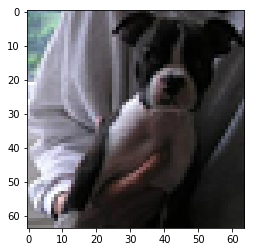

In [3]:
print(len(os.listdir('temp/cropped_images/')))
print(os.listdir('temp/cropped_images/')[10000])

im = Image.open(f"temp/cropped_images/{os.listdir('temp/cropped_images/')[10000]}")

plt.clf()
plt.figure()
plt.imshow(im)
plt.show()

model building

In [4]:
from keras.models import Sequential, Model, load_model
from keras.layers import UpSampling2D, Conv2D, Activation, BatchNormalization, Reshape, Dense, Input, LeakyReLU, Dropout, Flatten, ZeroPadding2D
from keras.optimizers import Adam

import glob
from PIL import Image
import numpy as np
import os
import argparse
from ast import literal_eval

#from scipy.misc import imsave
import matplotlib.image as mpimg

class DCGAN:
    def __init__(self, discriminator_path, generator_path, output_directory, img_size):
        self.img_size = img_size
        self.upsample_layers = 5
        self.starting_filters = 64
        self.kernel_size = 3
        self.channels = 3
        self.discriminator_path = discriminator_path
        self.generator_path = generator_path
        self.output_directory = output_directory

    def build_generator(self):
        noise_shape = (100,)

        # This block of code can be a little daunting, but essentially it automatically calculates the required starting
        # array size that will be correctly upscaled to our desired image size.
        #
        # We have 5 Upsample2D layers which each double the images width and height, so we can determine the starting
        # x size by taking (x / 2^upsample_count) So for our target image size, 256x192, we do the following:
        # x = (192 / 2^5), y = (256 / 2^5) [x and y are reversed within the model]
        # We also need a 3rd dimension which is chosen relatively arbitrarily, in this case it's 64.
        model = Sequential()
        model.add(
            Dense(self.starting_filters * (self.img_size[0] // (2 ** self.upsample_layers))  *  (self.img_size[1] // (2 ** self.upsample_layers)),
                  activation="relu", input_shape=noise_shape))
        model.add(Reshape(((self.img_size[0] // (2 ** self.upsample_layers)),
                           (self.img_size[1] // (2 ** self.upsample_layers)),
                           self.starting_filters)))
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling2D())  # 6x8 -> 12x16
        model.add(Conv2D(1024, kernel_size=self.kernel_size, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling2D())  # 12x16 -> 24x32
        model.add(Conv2D(512, kernel_size=self.kernel_size, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling2D())  # 24x32 -> 48x64
        model.add(Conv2D(256, kernel_size=self.kernel_size, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling2D())  # 48x64 -> 96x128
        model.add(Conv2D(128, kernel_size=self.kernel_size, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling2D())  # 96x128 -> 192x256
        model.add(Conv2D(64, kernel_size=self.kernel_size, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(32, kernel_size=self.kernel_size, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(self.channels, kernel_size=self.kernel_size, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_size[0], self.img_size[1], self.channels)

        model = Sequential()

        model.add(Conv2D(32, kernel_size=self.kernel_size, strides=2, input_shape=img_shape, padding="same"))  # 192x256 -> 96x128
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, kernel_size=self.kernel_size, strides=2, padding="same"))  # 96x128 -> 48x64
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(128, kernel_size=self.kernel_size, strides=2, padding="same"))  # 48x64 -> 24x32
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(256, kernel_size=self.kernel_size, strides=1, padding="same"))  # 24x32 -> 12x16
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(512, kernel_size=self.kernel_size, strides=1, padding="same"))  # 12x16 -> 6x8
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

    def build_gan(self):
        optimizer = Adam(0.0002, 0.5)

        # See if the specified model paths exist, if they don't then we start training new models

        if os.path.exists(self.discriminator_path) and os.path.exists(self.generator_path):
            self.discriminator = load_model(self.discriminator_path)
            self.generator = load_model(self.generator_path)
            print("Loaded models...")
        else:
            self.discriminator = self.build_discriminator()
            self.discriminator.compile(loss='binary_crossentropy',
                                       optimizer=optimizer,
                                       metrics=['accuracy'])

            self.generator = self.build_generator()
            self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # These next few lines setup the training for the GAN model
        z = Input(shape=(100,))
        img = self.generator(z)

        self.discriminator.trainable = False

        valid = self.discriminator(img)

        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def load_imgs(self, image_path):
        X_train = []
        for i in glob.glob(image_path):
            img = Image.open(i)
            img = np.asarray(img)
            X_train.append(img)
        return np.asarray(X_train)

    def train(self, epochs, image_path, batch_size=32, save_interval=50):
        self.build_gan()
        X_train = self.load_imgs(image_path)
        print("Training Data Shape: ", X_train.shape)

        # Rescale images from -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        half_batch = batch_size // 2

        for epoch in range(epochs):


            # Train Generator
            noise = np.random.normal(0, 1, (batch_size, 100))
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))



            # Train Discriminator
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            # Sample noise and generate a half batch of new images
            noise = np.random.normal(0, 1, (half_batch, 100))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Print progress
            print(f"{epoch} [D loss: {d_loss[0]} | D Accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

            # If at save interval => save generated image samples, save model files
            if epoch % (save_interval) == 0:

                self.save_imgs(epoch)

                save_path = self.output_directory + "/models"
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                self.discriminator.save(save_path + "/discrim.h5")
                self.generator.save(save_path + "/generat.h5")

    def gene_imgs(self, count):
        # Generate images from the currently loaded model
        noise = np.random.normal(0, 1, (count, 100))
        return self.generator.predict(noise)

    def save_imgs(self, epoch):
        r, c = 5, 5

        # Generates r*c images from the model, saves them individually and as a gallery

        imgs = self.gene_imgs(r*c)
        imgs = 0.5 * imgs + 0.5

        for i, img_array in enumerate(imgs):
            path = f"{self.output_directory}/generated_{self.img_size[0]}x{self.img_size[1]}"
            if not os.path.exists(path):
                os.makedirs(path)
            mpimg.imsave(path + f"/{epoch}_{i}.png", img_array)

        nindex, height, width, intensity = imgs.shape
        nrows = nindex // c
        assert nindex == nrows * c
        # want result.shape = (height*nrows, width*ncols, intensity)
        gallery = (imgs.reshape(nrows, c, height, width, intensity)
                  .swapaxes(1, 2)
                  .reshape(height * nrows, width * c, intensity))

        path = f"{self.output_directory}/gallery_generated_{self.img_size[0]}x{self.img_size[1]}"
        if not os.path.exists(path):
            os.makedirs(path)
        mpimg.imsave(path + f"/{epoch}.png", gallery)

    def generate_imgs(self, count, threshold, modifier):
        self.build_gan()

        # Generates (count) images from the model ensuring the discriminator scores them between the threshold values
        # and saves them

        imgs = []
        for i in range(count):
            score = [0]
            #while not(threshold[0] < score[0] < threshold[1]):
            img = self.gene_imgs(1)
            score = self.discriminator.predict(img)    
            print("Image found: ", score[0])
            imgs.append(img)

        imgs = np.asarray(imgs).squeeze()
        imgs = 0.5 * imgs + 0.5

        print(imgs.shape)
        for i, img_array in enumerate(imgs):
            path = f"{self.output_directory}/images"
            if not os.path.exists(path):
                os.makedirs(path)
            mpimg.imsave(path + f"/{i}.png", img_array)


Using TensorFlow backend.


training step

In [5]:
load_discriminator=''
load_generator=''
output_directory = 'output'
image_size = (64,64)
epochs = 10
data = 'temp/cropped_images/*.png'
batch_size = 32
save_interval = 1000


dcgan = DCGAN(load_discriminator, load_generator, output_directory, image_size)
dcgan.train(epochs=int(epochs), image_path=data, batch_size=int(batch_size), save_interval=int(save_interval))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 17, 17, 64)        0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 17, 17, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 17, 64)        0         
__________

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.7855815887451172 | D Accuracy: 25.0] [G loss: 0.7515398859977722]
1 [D loss: 0.6868038177490234 | D Accuracy: 50.0] [G loss: 0.33699798583984375]
2 [D loss: 0.9166587591171265 | D Accuracy: 46.875] [G loss: 1.4820008277893066]
3 [D loss: 1.0072507858276367 | D Accuracy: 34.375] [G loss: 1.327970027923584]
4 [D loss: 0.8209983110427856 | D Accuracy: 40.625] [G loss: 1.0446863174438477]
5 [D loss: 0.7447516918182373 | D Accuracy: 40.625] [G loss: 1.0647389888763428]
6 [D loss: 0.7467631101608276 | D Accuracy: 50.0] [G loss: 1.2277672290802002]
7 [D loss: 1.063934564590454 | D Accuracy: 15.625] [G loss: 1.4287500381469727]
8 [D loss: 0.9286153316497803 | D Accuracy: 18.75] [G loss: 1.0620229244232178]
9 [D loss: 0.8640480041503906 | D Accuracy: 25.0] [G loss: 1.2430238723754883]


generating step

In [6]:
sample=10
sample_thresholds = (0.0, 1.0)

dcgan.generate_imgs(sample, sample_thresholds, "")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 17, 17, 64)        0         
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 17, 17, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 17, 17, 64)        0         
__________

create zip file

In [7]:
import shutil

print(len(os.listdir('output/images/')))
shutil.make_archive('images', 'zip', 'output/images')
!ls

10
__notebook_source__.ipynb  images.zip  output  temp
